In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 10
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

import os
import glob


import warnings
warnings.filterwarnings('ignore')

# Import Data

#### Zendesk Agg

In [2]:
path = '../../Data/Zendesk/'

df_tickets_agg = pd.DataFrame()
for f in glob.glob(path + "*.xlsx"):
    df = pd.read_excel(f)
    df_tickets_agg = df_tickets_agg.append(df,ignore_index=True)

#### Metabase data

In [3]:
df_checkins = (pd.read_csv('../../Data/Metabase/checkins.csv')
                 .filter(['person_id', 'count checkin'])
                 .rename(columns={'count checkin':'Count_checkin'})
              )
df_plans = pd.read_csv('../../Data/Metabase/plan_values.csv').rename(columns={'max': 'Plan_value'})

In [4]:
df_cancel_1 = pd.read_csv('../../Data/Metabase/cancelamentos_1.csv')
df_cancel_2 = pd.read_csv('../../Data/Metabase/cancelamentos_2.csv')
df_cancel = (pd.concat([df_cancel_1, df_cancel_2])
               .filter(['person_id', 'change_to_type']))

# creatin cancelation flag
df_cancel = (df_cancel.groupby('person_id').count()
                      .reset_index()
                      .sort_values('change_to_type', ascending=False)
                      .assign(Cancel=1))

In [5]:
df_agg = pd.merge(df_tickets_agg, df_plans, how='left', left_on='Requester_ID', right_on='person_id')
df_agg = pd.merge(df_agg, df_checkins, how='left', left_on='Requester_ID', right_on='person_id')
df_agg = pd.merge(df_agg, df_cancel, how='left', left_on='Requester_ID', right_on='person_id')

In [6]:
df_agg = df_agg.filter(['Requester_ID', 'Month', 'Volume_7days', 'Volume_15days',
                'Volume_Monthly', 'ReclameAqui', 'SocialMedia', 'Tempo_Medio_Chat',
                'Tempo_Medio_Email', 'AWT_Chat', '%NFCR', '%Insatisfação(CSAT)',
                'CSAT_Rated', 'Plan_value', 'Count_checkin', 'Cancel'])

In [7]:
df_agg.isnull().mean() * 100

Requester_ID            0.000000
Month                   0.000000
Volume_7days            0.000000
Volume_15days           0.000000
Volume_Monthly          0.000000
ReclameAqui             0.000000
SocialMedia             0.000000
Tempo_Medio_Chat        0.000000
Tempo_Medio_Email       0.331729
AWT_Chat                0.000000
%NFCR                   0.000000
%Insatisfação(CSAT)     0.000000
CSAT_Rated              0.000000
Plan_value             36.749184
Count_checkin          44.993903
Cancel                 86.606920
dtype: float64

<AxesSubplot:>

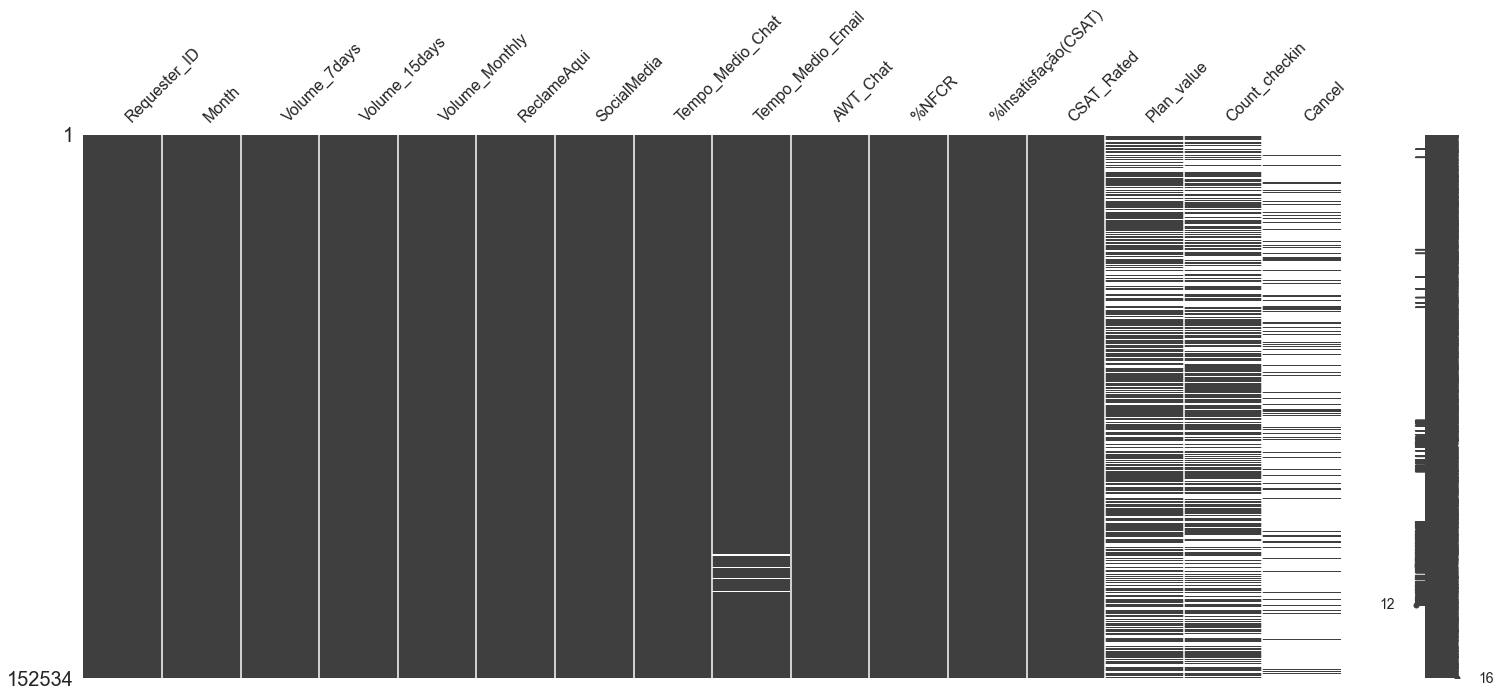

In [8]:
import missingno as msno
%matplotlib inline
msno.matrix(df_agg)

# Data Manipulation

#### Data Preparation

In [9]:
# Every Volume Chat, E-mail, Social NaN is zero
df_agg.Tempo_Medio_Chat.loc[df_agg.Tempo_Medio_Chat.isna()] = 0
df_agg.Tempo_Medio_Email.loc[df_agg.Tempo_Medio_Email.isna()] = 0

# Assuming that checkin==NaN is everyone who has median checked in (can be mistake on matebase query)
df_agg['Count_checkin'].loc[df_agg['Count_checkin'].isna()] = df_agg.Count_checkin.median()

# Assuming that cancel is NaN is every one who has not tried to cancel (can be mistake on matebase query)
df_agg.Cancel.loc[df_agg.Cancel.isna()] = 0

df_agg.Plan_value[df_agg.Plan_value.isna()] = df_agg.Plan_value.median()

df_agg.AWT_Chat.loc[df_agg.AWT_Chat.isna()] = 0

In [10]:
#from pandas_profiling import ProfileReport
#prof = ProfileReport(df_agg)
#prof

#### Target Creation

In [11]:
df_agg['Target'] = 0

df_agg.Target.loc[#(df_agg.Volume_7days>3) |
                  #(df_agg.Volume_15days>3) |
                  #(df_agg.Volume_Monthly>3) |
                   (df_agg.ReclameAqui=='yes') 
                   #(df_agg['%Insatisfação(CSAT)']==1) |
                   #(df_agg['%NFCR']==1)
                   ] = 1

0    152131
1       403
Name: Target, dtype: int64 



<AxesSubplot:title={'center':'target'}>

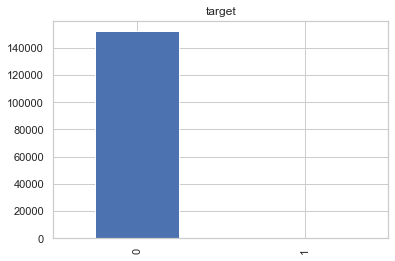

In [12]:
print(df_agg.Target.value_counts(), '\n')
df_agg.Target.value_counts().plot(kind='bar', title='target')

# Modeling

#### Modeling With DownSamples

In [13]:
df = df_agg

In [16]:
# Down-sample majority class
from sklearn.utils import resample

df_majority = df[df.Target == 0]
df_minority = df[df.Target == 1]

df_majority_downsampled = resample(df_majority,
                                   replace=False,
                                   n_samples=df_minority.shape[0],
                                   random_state=42)

df_downsampled = pd.concat([df_majority_downsampled, df_minority])

df_downsampled.reset_index(drop=True, inplace=True)
df_downsampled.Target.value_counts()

1    403
0    403
Name: Target, dtype: int64

#### Traning and Testing sets

In [26]:
features = ['Volume_7days', 'Volume_15days',
            'Volume_Monthly', 'Tempo_Medio_Chat',
            'Tempo_Medio_Email', 'AWT_Chat',
            '%NFCR', '%Insatisfação(CSAT)',
            'CSAT_Rated', 'Plan_value', 
            'Count_checkin', 'Cancel']

In [27]:
from sklearn.model_selection import train_test_split
y = df_downsampled.Target
X = df_downsampled.filter(features)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [28]:
X_train.head(3)

,Volume_7days,Volume_15days,Volume_Monthly,Tempo_Medio_Chat,Tempo_Medio_Email,AWT_Chat,%NFCR,%Insatisfação(CSAT),CSAT_Rated,Plan_value,Count_checkin,Cancel
181,0,3,3,320.146,0.000000,13.0,0.666667,0.0,0,349.99,19.0,0.0
411,0,1,1,0.000,8219.166667,0.0,0.000000,1.0,1,359.90,26.0,0.0
367,1,1,1,345.265,0.000000,33.0,1.000000,0.0,1,119.90,15.0,0.0


## Decision Tree

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

classifier_tree = DecisionTreeClassifier(random_state=42, max_depth=3)
classifier_tree = classifier_tree.fit(X_train, y_train)
# Predicting the Test set results
y_pred_tree = classifier_tree.predict(X_test)

Accuracy = 0.65 
Recall = 0.56


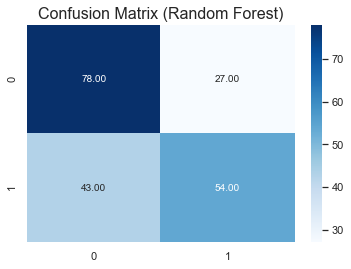

In [30]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score

print(f'Accuracy = {accuracy_score(y_test, y_pred_tree):.2f} \nRecall = {recall_score(y_test, y_pred_tree):.2f}')

cm_rf = confusion_matrix(y_test, y_pred_tree)
plt.title('Confusion Matrix (Random Forest)', size=16)
sns.heatmap(cm_rf, annot=True, fmt='.2f', cmap='Blues')
plt.show()

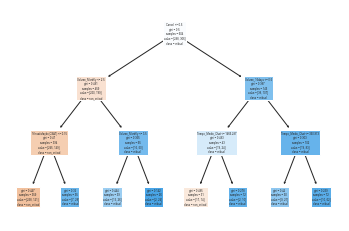

In [31]:
from sklearn import tree
_ = tree.plot_tree(classifier_tree,
                   feature_names=X_train.columns,
                   class_names=['non_critical', 'critical'], # Names of each of the target classes in ascending numerical order.
                   filled=True)

## Random  Forest

In [32]:
# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier_rf = RandomForestClassifier(n_estimators = 100,
                                       max_depth=5,
                                       criterion = 'entropy', 
                                       random_state = 42)
classifier_rf.fit(X_train, y_train)

# Predicting the Test set results
y_pred_rf = classifier_rf.predict(X_test)

# K-foldcross validation
from sklearn.model_selection import cross_val_score
accuracies_rf = cross_val_score(estimator = classifier_rf, X = X_train, y = y_train, cv = 10, n_jobs = -1)
mean_rf = accuracies_rf.mean()
variance_rf = accuracies_rf.std()

Accuracy = 0.68 
Recall = 0.64


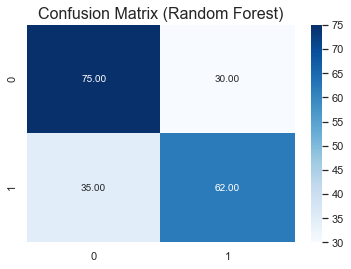

In [33]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score

print(f'Accuracy = {accuracy_score(y_test, y_pred_rf):.2f} \nRecall = {recall_score(y_test, y_pred_rf):.2f}')

cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.title('Confusion Matrix (Random Forest)', size=16)
sns.heatmap(cm_rf, annot=True, fmt='.2f', cmap='Blues')
plt.show()

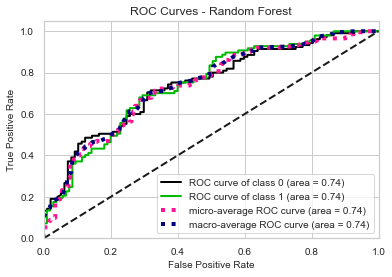

In [34]:
#ROC
import scikitplot as skplt #to make things easy
y_pred_proba = classifier_rf.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, y_pred_proba)
plt.title("ROC Curves - Random Forest")
plt.show()

Text(0.5, 0, 'Random Forest Feature Importance')

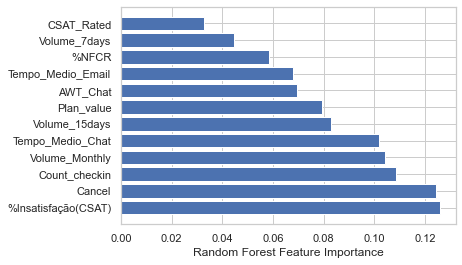

In [35]:
fi = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': classifier_rf.feature_importances_}).\
                    sort_values('importance', ascending = False)
plt.barh(fi.feature,fi.importance)
plt.xlabel("Random Forest Feature Importance")

### Output Model

In [ ]:
X_test

In [ ]:
df_output = X_test.assign(Pred=classifier_rf.predict_proba(X_test)[:,-1])

In [ ]:
df_output.head(3)

In [ ]:
rescaled = mms.inverse_transform(df_output[to_scale])
rescaled = pd.DataFrame(rescaled, columns=to_scale)
for col in rescaled:
    df_output[col] = rescaled[col]

In [ ]:
rescaled